# Taxi-V2

Mini project in [Udacity Deep Reinforcement Learning](http://bit.ly/drlndlinks) course, [module 8.1-8.3](https://classroom.udacity.com/nanodegrees/nd893/parts/8f607726-757e-4ef5-8b64-f2368755b89a/modules/a85374fa-6a60-425b-a480-85b211c5bd5d/lessons/508d0cf2-7545-48e8-95a0-7ac9467cfad7/concepts/ddb32ccb-2ae0-4c9d-82b0-f45e07271beb)

This notebook is an annotated version of the write up by [jo4x962k7JL](https://github.com/jo4x962k7JL/OpenAI-Gym-Taxi-v2).

First we examine the **Taxi-v2** environment, displaying and executing a few methods

In [1]:
from collections import deque, defaultdict
import sys, math, random
import numpy as np
import gym
import time
from IPython.display import display, clear_output

In [2]:
env = gym.make('Taxi-v2')
_ = [print(item) for item in dir(env) if not item.startswith('_')]

action_space
class_name
close
compute_reward
env
metadata
observation_space
render
reset
reward_range
seed
spec
step
unwrapped


In [3]:
env.action_space

Discrete(6)

In [4]:
env.observation_space

Discrete(500)

    rendering:
    - blue: passenger
    - magenta: destination
    - yellow: empty taxi
    - green: full taxi
    - other letters: locations

In [5]:
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



States are coded numerically as products of the four numbers: 

```taxirow * 5, taxicol * 5, passidx * 4, destidx```

where 
- rows, columns range from 0 to 4 
- passenger index range from 0 to 4 (with 4 being used to flag the passenger being in the taxi)
- destination index ranges from 0 to 3

Note that the STARTING passenger index and destination index are never the same, so the "trip" always requires a pickup at one index and drop off at another. Since a time step is used for the pick up and drop off, the maximum possible reward is 20 - 1 (pickup) - 4 (steps to get between R and Y) - 1 (drop off) = 14.

In [6]:
def decode(i):
    out = []
    out.append(i % 4)
    i = i // 4
    out.append(i % 5)
    i = i // 5
    out.append(i % 5)
    i = i // 5
    out.append(i)
    assert 0 <= i < 5
    return reversed(out)

In [7]:
taxirow, taxicol, passidx, destidx = decode(1)
print(taxirow, taxicol, passidx, destidx)

0 0 0 1


We define an **Agent** (a taxi) with a Q table that will ultimately hold arrays of 6 values (one for each possible action) for each of the 500 states.

Update the Q table via **Sarasamax** (Q-Learning) - Algorithm 14:
\begin{equation*}
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha ( R_{t+1} + \gamma max_a Q ( S_{t+1} , a ) - Q(S_t,A_t) ) 
\end{equation*}
Equivalently (implemented on lines 25-26):
\begin{equation*}
Q(S_t,A_t) \leftarrow ( 1 - \alpha ) Q(S_t,A_t) + \alpha ( R_{t+1} + \gamma max_a Q ( S_{t+1} , a ) ) 
\end{equation*}

In [8]:
class Agent:
    def __init__(self, nA=6, 
                 eps_range=[1e-3, 1e-6], 
                 alpha_range=[1e-2, 1e-3], 
                 gamma_range=[0.99, 0.8], 
                 decay_steps=50000):
        self.nA = nA
        self.Q = defaultdict(lambda: np.zeros(self.nA))
        self.decay_steps = decay_steps
        self.epsilons = np.linspace(eps_range[0], eps_range[1], self.decay_steps)
        self.alphas = np.linspace(alpha_range[0], alpha_range[1], self.decay_steps)
        self.gammas = np.linspace(gamma_range[0], gamma_range[1], self.decay_steps)
        
    def select_action(self, state, i_episode):
        self.epsilon = self.epsilons[min(i_episode, self.decay_steps-1)]
        self.alpha = self.alphas[min(i_episode, self.decay_steps-1)]
        self.gamma = self.gammas[min(i_episode, self.decay_steps-1)]
        qmax_index = np.argmax(self.Q[state])
        if random.uniform(0, 1) > self.epsilon:
            return qmax_index
        else:
            return random.randrange(self.nA)
        
    def step(self, state, action, reward, next_state, done):
        new_value = (1 - self.alpha) * self.Q[state][action] + \
            self.alpha * (reward + self.gamma * np.max(self.Q[next_state]))
        self.Q[state][action] = new_value

In [9]:
def interact(env, agent, num_episodes=100000, window=100):
    avg_rewards = list()
    best_avg_reward = -math.inf
    samp_rewards = deque(maxlen=window)
    
    # initialize history deques
    alpha_history = deque(maxlen=num_episodes)
    gamma_history = deque(maxlen=num_episodes)
    epsilon_history = deque(maxlen=num_episodes)

    for i_episode in range(1, num_episodes+1):
        state = env.reset()
        samp_reward = 0
        while True:
            action = agent.select_action(state, i_episode)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            samp_reward += reward
            # every 10000 episodes
            if i_episode % 10000 == 0:
                # show the state
                clear_output(wait=True)
                print('i_episode:{}'.format(i_episode))
                print('state:{} reward:{} total reward:{}'.format(state, reward, samp_reward))
                env.render()
                time.sleep(0.2)
            state = next_state
            if done:
                samp_rewards.append(samp_reward)
                break
        if (i_episode >= 100):
            avg_reward = np.mean(samp_rewards)
            avg_rewards.append(avg_reward)
            
            # append to histories
            alpha_history.append(agent.alpha)
            gamma_history.append(agent.gamma)
            epsilon_history.append(agent.epsilon)
            
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
        print("\rEpisode {}: epsilon = {:.8f}, alpha = {:.5f}, gamma = {:.3f} | Max reward: {:.3f} | Best average: {:.3f}".format(
            i_episode, agent.epsilon, agent.alpha, agent.gamma, max(samp_rewards), best_avg_reward), end="")
        sys.stdout.flush()
        
        # check if task is solved (according to OpenAI Gym)
        if best_avg_reward >= 9.7:
            print('\nEnvironment solved in {} episodes.'.format(i_episode), end="")
            break
        if i_episode == num_episodes: print('\n')
    return avg_rewards, best_avg_reward, (alpha_history, gamma_history, epsilon_history)

In [10]:
env = gym.make('Taxi-v2')
agent = Agent()
avg_rewards, best_avg_reward, history_tuple = interact(env, agent, num_episodes=30000)

i_episode:30000
state:16 reward:20 total reward:11
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Episode 30000: epsilon = 0.00040059, alpha = 0.00460, gamma = 0.876 | Max reward: 15.000 | Best average: 9.250



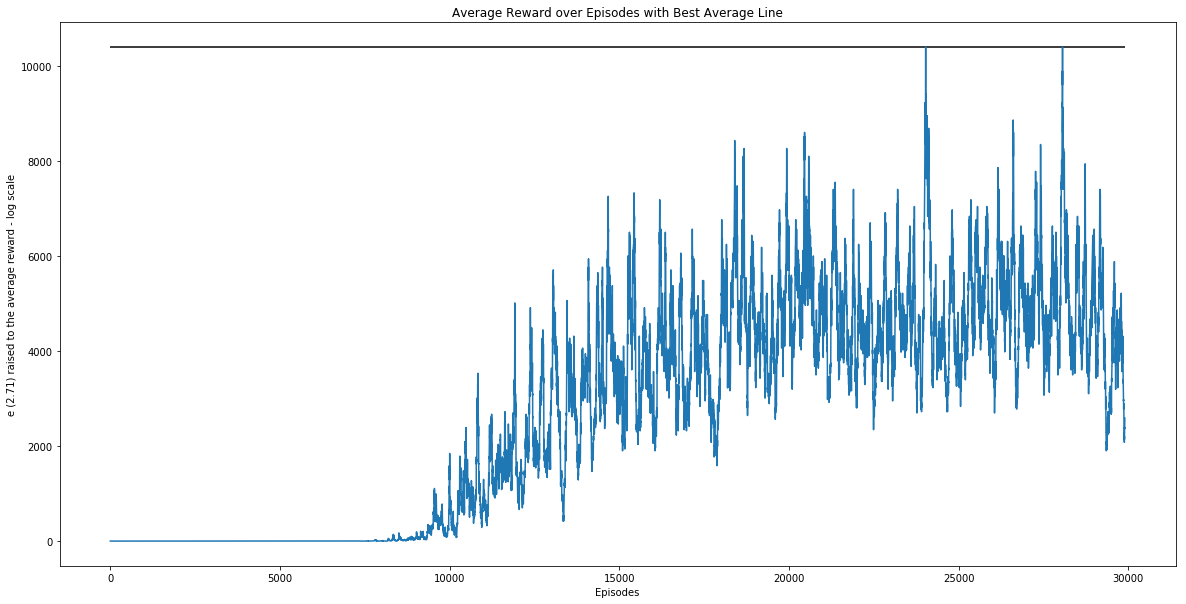

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20, 10))
plt.title('Average Reward over Episodes with Best Average Line')
plt.xlabel('Episodes')
plt.ylabel('e (2.71) raised to the average reward - log scale')
plt.hlines(np.exp(best_avg_reward), 0 , len(avg_rewards))
plt.plot(np.exp(avg_rewards))
plt.show()

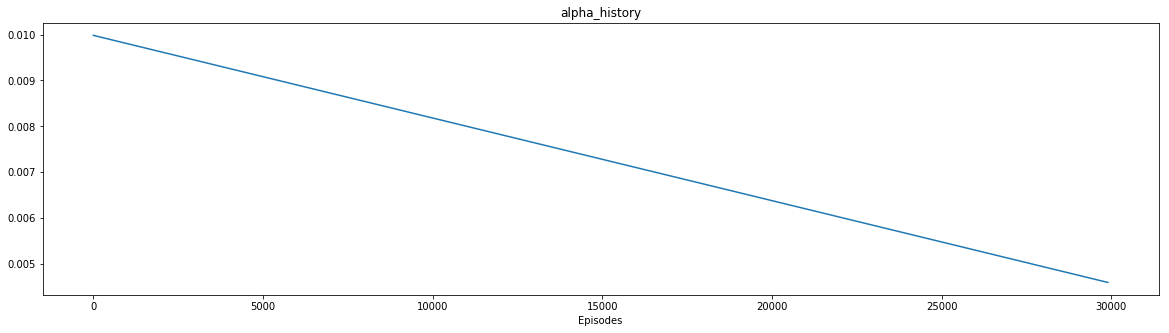

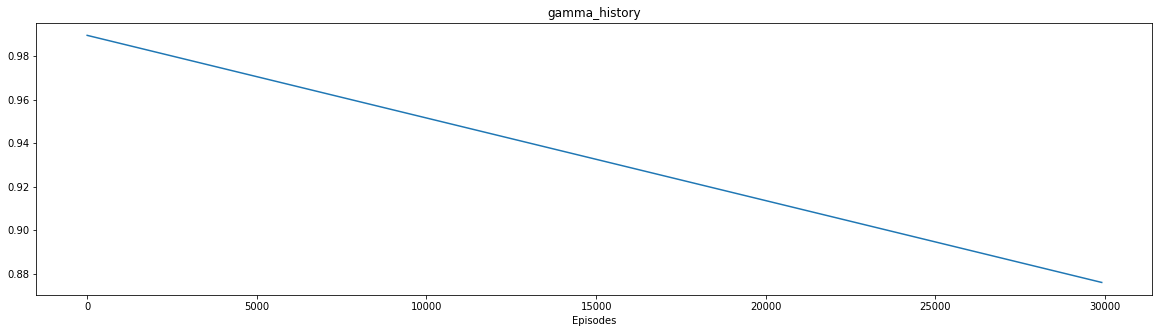

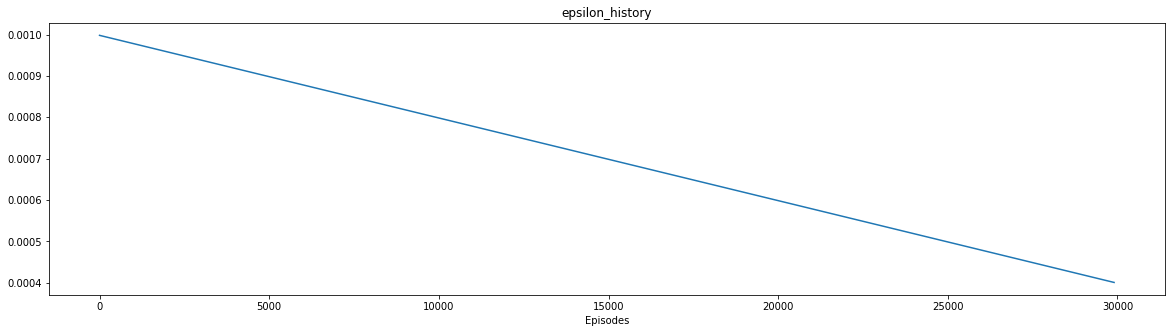

In [12]:
history_title = ['alpha_history', 'gamma_history', 'epsilon_history']
for index, title in enumerate(history_title):
    plt.figure(figsize=(20, 5))
    plt.title(title)
    plt.xlabel('Episodes')
    plt.plot(history_tuple[index])
    plt.show()

In [13]:
print(sorted(list(agent.Q.keys()))[:16])
print("...")
print(sorted(list(agent.Q.keys()))[-16:])

[1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19]
...
[481, 482, 483, 484, 486, 487, 488, 489, 491, 492, 493, 494, 496, 497, 498, 499]


In [14]:
agent.Q[1]

array([ -2.11148519,  -2.11511966,  -2.12170162,  -2.11511966,
       129.69386656,  -2.15039918])

Notice some states missing?
```
0 [0, 0, 0, 0]

5 [0, 0, 1, 1]

10 [0, 0, 2, 2]

15 [0, 0, 3, 3]
```

In [15]:
decoded_Q = {}
for key in agent.Q.keys():
    decoded_Q[key] = decode(key)
for key in sorted(list(agent.Q.keys()))[:16]:
    print(key, list(decoded_Q[key]))
print('...')
for key in sorted(list(agent.Q.keys()))[-16:]:
    print(key, list(decoded_Q[key]))

1 [0, 0, 0, 1]
2 [0, 0, 0, 2]
3 [0, 0, 0, 3]
4 [0, 0, 1, 0]
6 [0, 0, 1, 2]
7 [0, 0, 1, 3]
8 [0, 0, 2, 0]
9 [0, 0, 2, 1]
11 [0, 0, 2, 3]
12 [0, 0, 3, 0]
13 [0, 0, 3, 1]
14 [0, 0, 3, 2]
16 [0, 0, 4, 0]
17 [0, 0, 4, 1]
18 [0, 0, 4, 2]
19 [0, 0, 4, 3]
...
481 [4, 4, 0, 1]
482 [4, 4, 0, 2]
483 [4, 4, 0, 3]
484 [4, 4, 1, 0]
486 [4, 4, 1, 2]
487 [4, 4, 1, 3]
488 [4, 4, 2, 0]
489 [4, 4, 2, 1]
491 [4, 4, 2, 3]
492 [4, 4, 3, 0]
493 [4, 4, 3, 1]
494 [4, 4, 3, 2]
496 [4, 4, 4, 0]
497 [4, 4, 4, 1]
498 [4, 4, 4, 2]
499 [4, 4, 4, 3]


In [16]:
len(agent.Q.keys())

400

So, wait, the Q table only has 400 entries for the 500 possible states?

Let's make a Q table for all 500 states.

In [17]:
Q_for_all_500_states = {key:[.0, .0, .0, .0, .0, .0] for key in np.arange(500)}
for key in agent.Q.keys():
    Q_for_all_500_states[key] = agent.Q[key]

In [18]:
len(Q_for_all_500_states)

500

In [19]:
passenger_destination_pairs = {}
for key in Q_for_all_500_states.keys():
    taxirow, taxicol, passidx, destidx = decode(key)
    if (passidx, destidx) in passenger_destination_pairs:
        passenger_destination_pairs[(passidx, destidx)][key] = Q_for_all_500_states[key]
    else:
        passenger_destination_pairs[(passidx, destidx)]= {key: Q_for_all_500_states[key]}
len(passenger_destination_pairs.keys())

20

Now we can plot the Q tables for each of these 20 situations

In [20]:
passenger_destination_pairs.keys()

dict_keys([(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3), (4, 0), (4, 1), (4, 2), (4, 3)])

In [21]:
for key in passenger_destination_pairs.keys():
    print(key, len(passenger_destination_pairs[key]))

(0, 0) 25
(0, 1) 25
(0, 2) 25
(0, 3) 25
(1, 0) 25
(1, 1) 25
(1, 2) 25
(1, 3) 25
(2, 0) 25
(2, 1) 25
(2, 2) 25
(2, 3) 25
(3, 0) 25
(3, 1) 25
(3, 2) 25
(3, 3) 25
(4, 0) 25
(4, 1) 25
(4, 2) 25
(4, 3) 25


In [22]:
def plot_qtable(V):
    # reshape the state-value function
    V = np.reshape(V, (5,5))
    # plot the state-value function
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(V, cmap='cool')
    for (j,i),label in np.ndenumerate(V):
        ax.text(i, j, np.round(label,3), ha='center', va='center', fontsize=14)
    plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
    plt.title('State-Value Function')
    plt.show()

Passenger at 0 going to Destination 0


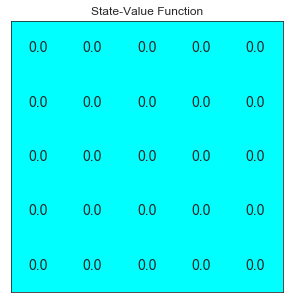

Passenger at 0 going to Destination 1


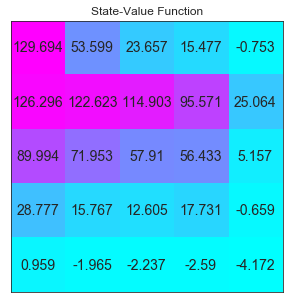

Passenger at 0 going to Destination 2


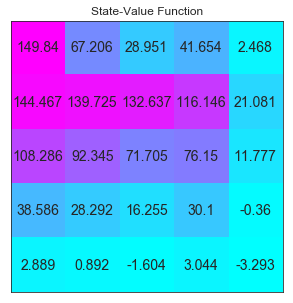

Passenger at 0 going to Destination 3


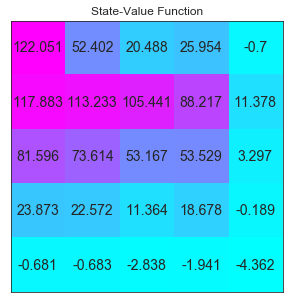

Passenger at 1 going to Destination 0


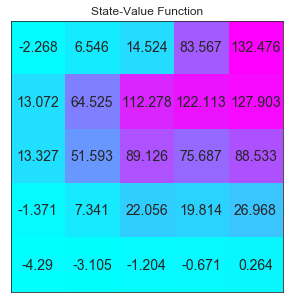

Passenger at 1 going to Destination 1


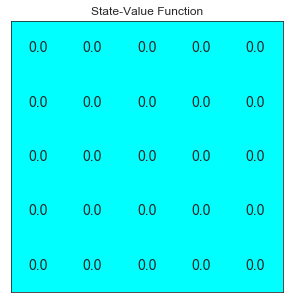

Passenger at 1 going to Destination 2


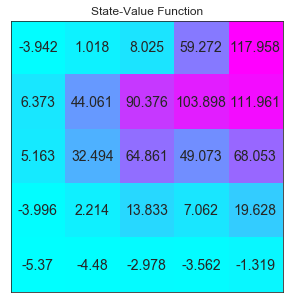

Passenger at 1 going to Destination 3


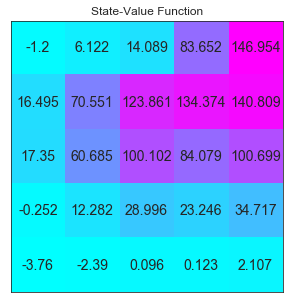

Passenger at 2 going to Destination 0


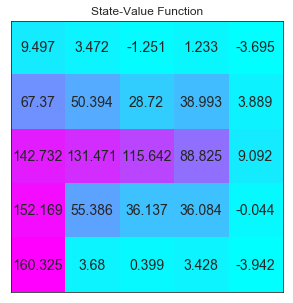

Passenger at 2 going to Destination 1


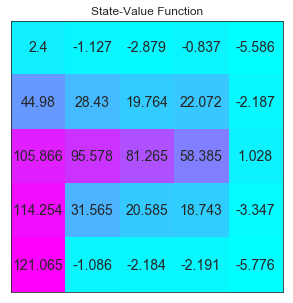

Passenger at 2 going to Destination 2


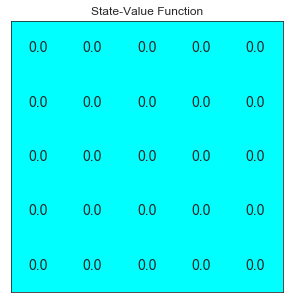

Passenger at 2 going to Destination 3


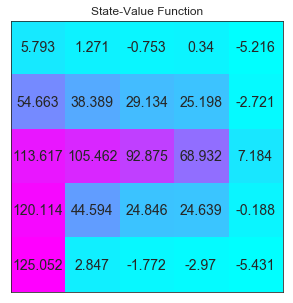

Passenger at 3 going to Destination 0


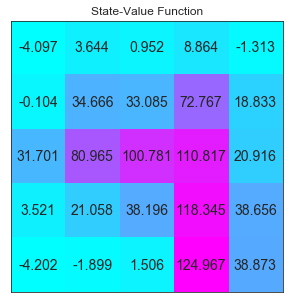

Passenger at 3 going to Destination 1


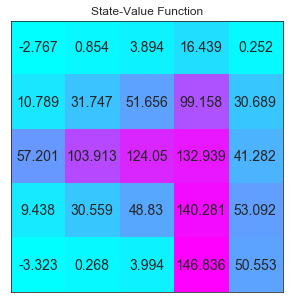

Passenger at 3 going to Destination 2


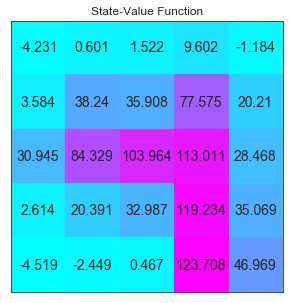

Passenger at 3 going to Destination 3


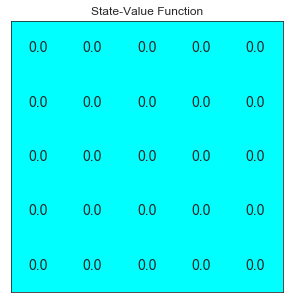

Passenger at 4 going to Destination 0 in Taxi


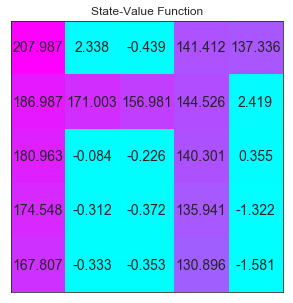

Passenger at 4 going to Destination 1 in Taxi


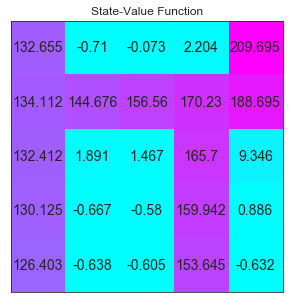

Passenger at 4 going to Destination 2 in Taxi


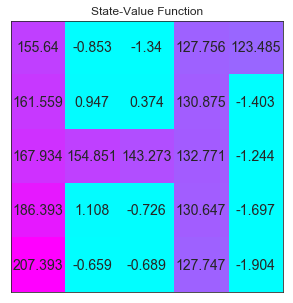

Passenger at 4 going to Destination 3 in Taxi


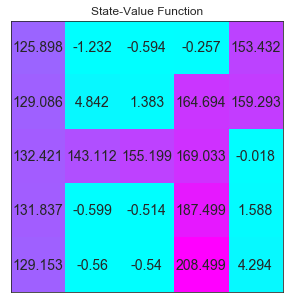

In [23]:
import seaborn as sns
sns.set_style("white")

for pair_key in passenger_destination_pairs.keys():
    if pair_key[0] == 4:
        in_taxi = " in Taxi"
    else:
        in_taxi = ""
    print("Passenger at {} going to Destination {}{}".format(pair_key[0], pair_key[1], in_taxi))
    # plot the estimated optimal state-value function
    Sarsamax_values = np.asarray([np.max(Q_for_all_500_states[key]) if key in passenger_destination_pairs[pair_key] else 0 for key in passenger_destination_pairs[pair_key].keys()])
    plot_qtable(Sarsamax_values)